In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [56]:
df = pd.read_csv('/home/data/MSN.csv')
df.tail()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
135349,MSN,12/22/2020 14:23,82.8,82.8,82.8,82.8,700,0
135350,MSN,12/22/2020 14:24,82.7,82.8,82.7,82.8,4660,0
135351,MSN,12/22/2020 14:25,82.8,82.8,82.8,82.8,50,0
135352,MSN,12/22/2020 14:27,82.8,82.8,82.8,82.8,300,0
135353,MSN,12/22/2020 14:46,82.8,82.8,82.8,82.8,200,0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [58]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

In [59]:
grouped = df.groupby(df['Date/Time'].dt.date)
dfs = [group for _, group in grouped]
df_day = pd.DataFrame()

for df1 in dfs:
    data = {
        'Open': df1['Open'].iloc[0],
        'Close': df1['Close'].iloc[-1],
        'Volume': df1['Volume'].sum(),
        'High': df1['High'].max(),
        'Low': df1['Low'].min(),
        'Date/Time': df1['Date/Time'].iloc[0]
    }
    df2 = pd.DataFrame(data, index=[0])
    df_day = pd.concat([df_day, df2])

df_day


,Open,Close,Volume,High,Low,Date/Time
0,73.10,74.2,207370,75.4,73.00,2017-12-25 09:15:00
0,74.90,75.5,403710,75.5,74.30,2017-12-26 09:15:00
0,74.90,75.0,517920,75.7,74.80,2017-12-27 09:15:00
0,75.00,75.7,377030,76.0,74.50,2017-12-28 09:15:00
0,76.00,76.7,226880,77.0,76.00,2017-12-29 13:35:00
...,...,...,...,...,...,...
0,83.01,83.5,648540,83.6,82.91,2020-12-16 09:15:00
0,83.50,84.0,1179730,84.3,82.90,2020-12-17 09:15:00
0,83.70,84.1,1417470,84.3,83.70,2020-12-18 09:15:00
0,85.00,83.8,827020,85.0,83.40,2020-12-21 09:15:00


In [60]:
df_day['Date/Time'] = pd.to_datetime(df_day['Date/Time'])

In [61]:
df_day['Date/Time'] = df_day['Date/Time'].dt.date

In [62]:
df_day.index = df_day['Date/Time']

In [71]:
df = df_day.copy()

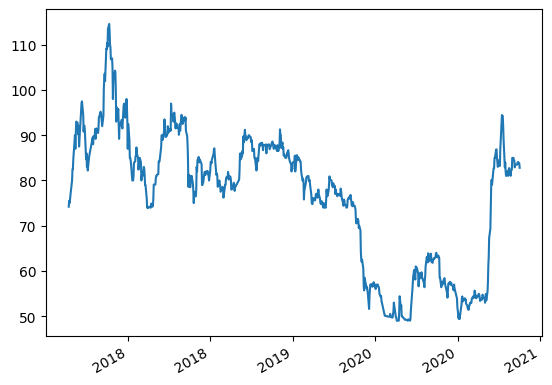

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(df.index, df['Close'])

ax.xaxis.set_major_locator(mdates.DayLocator(interval=200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()

plt.show()


In [106]:
window_df = pd.DataFrame()

window_df = df[['Close','Date/Time']].copy()
window_df['Target'] = window_df['Close']
window_df['Target-1']= window_df['Close'].shift(1)
window_df['Target-2']= window_df['Close'].shift(2)
window_df['Target-3']=window_df['Close'].shift(3)

window_df.drop(columns=['Close'],inplace=True)
window_df.dropna(inplace=True)

In [107]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(window_df)

dates.shape, X.shape, y.shape

((745,), (745, 3, 1), (745,))

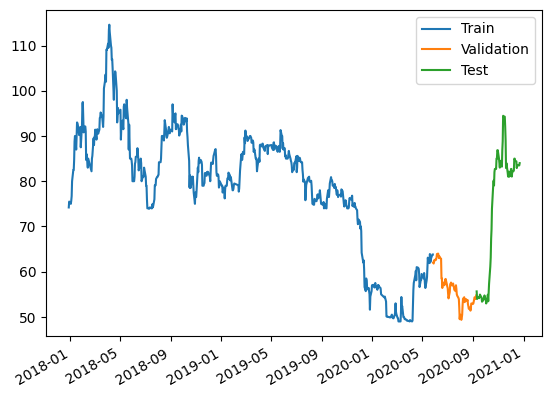

In [109]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()
plt.legend(['Train', 'Validation', 'Test'])

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
19/19 [==============================] - 3s 37ms/step - loss: 6403.6025 - mean_absolute_error: 78.8262 - val_loss: 3120.5176 - val_mean_absolute_error: 55.7244
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 6274.2456 - mean_absolute_error: 78.0006 - val_loss: 2959.7754 - val_mean_absolute_error: 54.2609
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 5945.9951 - mean_absolute_error: 75.8251 - val_loss: 2528.6184 - val_mean_absolute_error: 50.1228
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 5049.2188 - mean_absolute_error: 69.5904 - val_loss: 1600.0944 - val_mean_absolute_error: 39.7926
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 3387.9229 - mean_absolute_error: 56.2510 - val_loss: 581.2369 - val_mean_absolute_error: 23.7775
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 1568.1174 - mean_absolute_error: 36.4042 - val_loss: 16.1333 - val_mean_

19/19 [==============================] - 0s 2ms/step


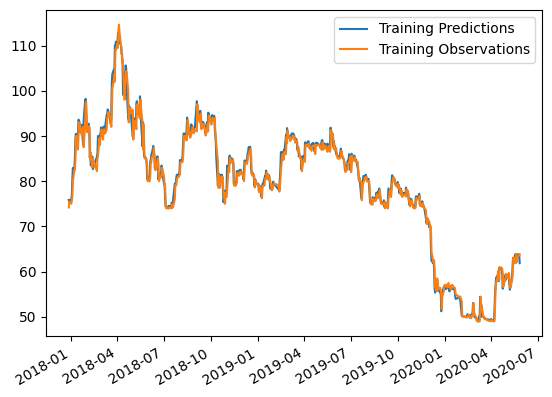

In [113]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 4ms/step


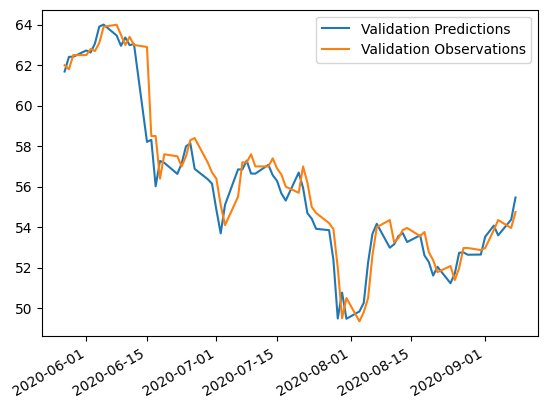

In [115]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 6ms/step


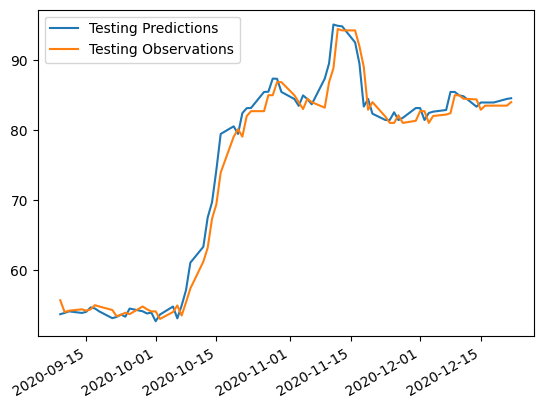

In [117]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.legend(['Testing Predictions', 'Testing Observations'])

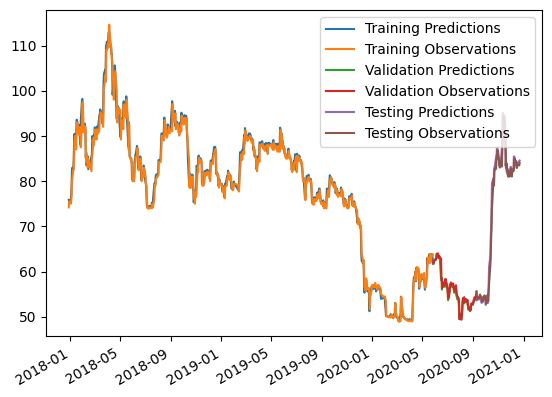

<Figure size 3000x1000 with 0 Axes>

In [121]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.figure(figsize=(30,10))
plt.show()